In [ ]:
! pip install gymnasium
! pip install gymnasium[box2d]

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import collections # For dequeue for the memory buffer
import random
import dill as pickle # For storing the buffer state

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MemoryBuffer(object):
    def __init__(self, max_size):
        self.memory_size = max_size
        self.trans_counter=0 # num of transitions in the memory
                             # this count is required to delay learning
                             # until the buffer is sensibly full
        self.index=0         # current pointer in the buffer
        self.buffer = collections.deque(maxlen=self.memory_size)
        self.transition = collections.namedtuple("Transition", field_names=["state", "action", "reward", "new_state", "terminal"])

    
    def save(self, state, action, reward, new_state, terminal):
        t = self.transition(state, action, reward, new_state, terminal)
        self.buffer.append(t)
        self.trans_counter = (self.trans_counter + 1) % self.memory_size

    def random_sample(self, batch_size):
        assert len(self.buffer) >= batch_size # should begin sampling only when sufficiently full
        transitions = random.sample(self.buffer, k=batch_size) # number of transitions to sample
        states = torch.from_numpy(np.vstack([e.state for e in transitions if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in transitions if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in transitions if e is not None])).float().to(device)
        new_states = torch.from_numpy(np.vstack([e.new_state for e in transitions if e is not None])).float().to(device)
        terminals = torch.from_numpy(np.vstack([e.terminal for e in transitions if e is not None]).astype(np.uint8)).float().to(device)
  
        return states, actions, rewards, new_states, terminals

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

class Agent(object):
    def __init__(self, lr, gamma, epsilon, batch_size,
                 epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000):
        self.gamma = gamma # alpha = learn rate, gamma = discount
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec # decrement of epsilon for larger spaces
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.memory = MemoryBuffer(mem_size)

    def save(self, state, action, reward, new_state, done):
        # self.memory.trans_counter += 1
        self.memory.save(state, action, reward, new_state, done)

    def choose_action(self, state):
        # state = state[np.newaxis, :]
        rand = np.random.random()
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.q_func.eval()
        with torch.no_grad():
            action_values = self.q_func(state)
        self.q_func.train()
        # print(state)
        if rand > self.epsilon: 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # exploring: return a random action
            return np.random.choice([i for i in range(4)])
            

    def reduce_epsilon(self):
        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                       self.epsilon_min else self.epsilon_min
        
        
    def learn(self):
        raise Exception("Not implemented")
        
    def plotLearning(self, x, scores, epsilons, filename, lines=None):
        fig=plt.figure()
        ax=fig.add_subplot(111, label="1")
        ax2=fig.add_subplot(111, label="2", frame_on=False)

        ax.plot(x, epsilons, color="C0")
        ax.set_xlabel("Game", color="C0")
        ax.set_ylabel("Epsilon", color="C0")
        ax.tick_params(axis='x', colors="C0")
        ax.tick_params(axis='y', colors="C0")

        N = len(scores)
        running_avg = np.empty(N)
        for t in range(N):
            running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

        ax2.scatter(x, running_avg, color="C1")
        #ax2.xaxis.tick_top()
        ax2.axes.get_xaxis().set_visible(False)
        ax2.yaxis.tick_right()
        #ax2.set_xlabel('x label 2', color="C1")
        ax2.set_ylabel('Score', color="C1")
        #ax2.xaxis.set_label_position('top')
        ax2.yaxis.set_label_position('right')
        #ax2.tick_params(axis='x', colors="C1")
        ax2.tick_params(axis='y', colors="C1")

        if lines is not None:
            for line in lines:
                plt.axvline(x=line)

        plt.savefig(filename)

    def save_model(self, path):
        torch.save(self.q_func.state_dict(), path)
        # with open(path + '.torch.memory.pickle', 'wb') as handle:
        #     pickle.dump(self.memory, handle, protocol=pickle.HIGHEST_PROTOCOL)



    def load_saved_model(self, path):
        self.q_func = QNetwork(8, 4, 42).to(device)
        self.q_func.load_state_dict(torch.load(path))
        self.q_func.eval()
        # with open(path + '.torch.memory.pickle', 'rb') as handle:
        #     self.memory = pickle.load(handle)
        
    
class SingleQAgent(Agent):
    def __init__(self, lr, gamma, epsilon, batch_size,
                 epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000):
        super().__init__(lr=lr, gamma=gamma, epsilon=epsilon, batch_size=batch_size,
                 epsilon_dec=epsilon_dec,  epsilon_end=epsilon_end,
                 mem_size=mem_size)
        
        self.q_func = QNetwork(8, 4, 42).to(device)
        self.optimizer = optim.Adam(self.q_func.parameters(), lr=lr)        
        
    def learn(self):
        if self.memory.trans_counter < self.batch_size: # wait before you start learning
            return
            
        # 1. Choose a sample from past transitions:
        states, actions, rewards, new_states, terminals = self.memory.random_sample(self.batch_size)
        
        
        # 2. Compute predicted q value for the sample states
        q = self.q_func(torch.from_numpy(states).type(torch.FloatTensor))
        # print(q.gather(1, torch.from_numpy(actions).type(torch.FloatTensor)))
        
        # 3. Compute (using the same Q network) q value for the new states
        q_next = self.q_func(torch.from_numpy(new_states).type(torch.FloatTensor))
        q_next_actions = q_next.max(1)[0]
        
        # 4. Improve the Q network
        inx = np.arange(self.batch_size, dtype=np.int32)
        q_updated = q.detach().numpy()
        q_updated[inx, actions] = rewards + self.gamma*q_next_actions.detach().numpy()*(1-terminals)
        
        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(q, q_next)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.q_func.parameters(), 100)
        self.optimizer.step()
        
        # 5. Reduce the exploration rate
        self.reduce_epsilon()

        
class DoubleQAgent(Agent):
    def __init__(self, lr, gamma, epsilon, batch_size,
                 epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000, replace_q_target = 100):
        
        super().__init__(lr=lr, gamma=gamma, epsilon=epsilon, batch_size=batch_size,
             epsilon_dec=epsilon_dec,  epsilon_end=epsilon_end,
             mem_size=mem_size)

        self.replace_q_target = replace_q_target
        self.q_func = QNetwork(8, 4, 42).to(device)
        self.q_func_target = QNetwork(8, 4, 42).to(device)
        self.optimizer = optim.Adam(self.q_func.parameters(), lr=lr)
        
        
    def learn(self):
        if self.memory.trans_counter < self.batch_size: # wait before you start learning
            return
            
        # 1. Choose a sample from past transitions:
        states, actions, rewards, new_states, terminals = self.memory.random_sample(self.batch_size)
        
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.q_func_target(new_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + self.gamma * q_targets_next * (1 - terminals)
        ### Calculate expected value from local network
        q_expected = self.q_func(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        # self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        
        # 5. Reduce the exploration rate
        self.reduce_epsilon()
        
        if self.memory.trans_counter % self.replace_q_target == 0: # wait before you start learning
            for target_param, local_param in zip(self.q_func_target.parameters(), self.q_func.parameters()):
                target_param.data.copy_(local_param.data)


    def save_model(self, path):
        super().save_model(path)
        torch.save(self.q_func.state_dict(), path+'.target')


    def load_saved_model(self, path):
        super().load_saved_model(path)
        self.q_func_target = QNetwork(8, 4, 42).to(device)
        self.q_func_target.load_state_dict(torch.load(path+'.target'))
        self.q_func_target.eval()
    

Training a double DQN agent on 1500 episodes. Pretrained model = False
Episode 5 in 0.01 min. Expected total time for 1500 episodes: 3 min. [-93.09/-197.26]
Episode 10 in 0.02 min. Expected total time for 1500 episodes: 4 min. [-317.16/-222.09]
Episode 15 in 0.05 min. Expected total time for 1500 episodes: 5 min. [-842.00/-262.47]
Episode 20 in 0.06 min. Expected total time for 1500 episodes: 5 min. [-82.54/-217.49]
Episode 25 in 0.21 min. Expected total time for 1500 episodes: 13 min. [-98.35/-191.37]
Episode 30 in 0.31 min. Expected total time for 1500 episodes: 16 min. [-197.07/-176.96]
Episode 35 in 0.41 min. Expected total time for 1500 episodes: 18 min. [-59.83/-165.32]
Episode 40 in 0.49 min. Expected total time for 1500 episodes: 19 min. [-1.00/-155.72]
Episode 45 in 0.59 min. Expected total time for 1500 episodes: 20 min. [-106.91/-157.53]
Episode 50 in 0.70 min. Expected total time for 1500 episodes: 22 min. [-8.01/-150.20]
Episode 55 in 0.82 min. Expected total time for 1500

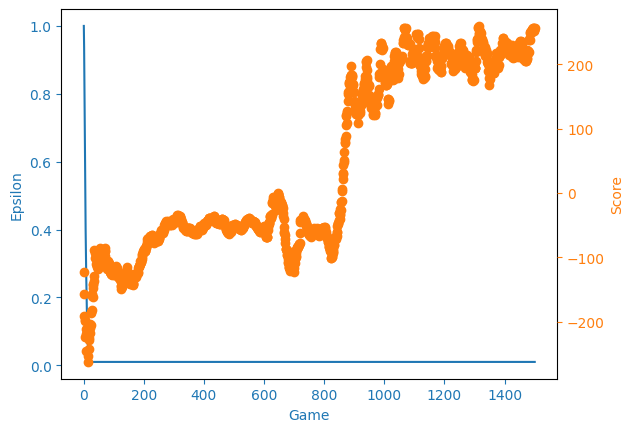

In [27]:
import gymnasium as gym
import os
import matplotlib.pyplot as plt
import json # for dumping debug data
import time # for benchmarking 

# os.environ["SDL_VIDEODRIVER"] = "dummy"
# from IPython.display import clear_output
LEARN_EVERY = 4
def train_agent(atype='double', n_episodes=2000, load_latest_model=False):
    print("Training a {} DQN agent on {} episodes. Pretrained model = {}".format(atype,n_episodes,load_latest_model))
    env = gym.make("LunarLander-v2")
    if atype == 'double':
        agent = DoubleQAgent(gamma=0.99, epsilon=1.0, epsilon_dec=0.995, lr=0.001, mem_size=200000, batch_size=128, epsilon_end=0.01)
    elif atype == 'single':
        agent = SingleQAgent(gamma=0.99, epsilon=1.0, epsilon_dec=0.996, lr=0.001, mem_size=200000, batch_size=128, epsilon_end=0.01)
    
    if load_latest_model:
        agent.load_saved_model('{}_dqn_model.h5'.format(atype))
        print('Loaded most recent {} model.'.format(atype))
        
    scores = []
    eps_history = []
    start = time.time()
    # times = []
    for i in range(n_episodes):
        terminated = False
        truncated = False
        score = 0
        state = env.reset()[0]
        steps = 0
        gametime = [0.0,0.0,0.0,0.0]
        while not (terminated or truncated):
            # t1 = time.time()
            action = agent.choose_action(state)
            # t2 = time.time()
            # print(action)
            new_state, reward, terminated, truncated, info = env.step(action)
            # t3 = time.time()
            agent.save(state, action, reward, new_state, terminated)
            # t4 = time.time()
            # t5 = 0
            state = new_state
            if steps > 0 and steps % LEARN_EVERY == 0:
                agent.learn()
                # t5 = time.time()
            steps += 1
            score += reward
            # gametime[0] += t2-t1
            # gametime[1] += t3-t2
            # gametime[2] += t4-t2
            # if t5>0:
            #    gametime[3] += t5-t4
        # times.append(gametime)
        # print(times)
        eps_history.append(agent.epsilon)

        scores.append(score)

        avg_score = np.mean(scores[max(0, i-100):(i+1)])

        if (i+1) % 5 == 0 and i > 0:
            print('Episode {} in {:.2f} min. Expected total time for {} episodes: {:.0f} min. [{:.2f}/{:.2f}]'.format((i+1), 
                                                                                                                      (time.time() - start)/60, 
                                                                                                                      n_episodes, 
                                                                                                                      (((time.time() - start)/i)*n_episodes)/60, 
                                                                                                                      score, 
                                                                                                                      avg_score))
            
        if (i+1) % 100 == 0 and i > 0:
            agent.save_model('{}_torch_dqn_model.h5'.format(atype))
            with open("{}_torch_dqn_scores_{}.json".format(atype, int(time.time())), "w") as fp:
                json.dump(scores, fp)
            with open("{}_torch_eps_history_{}.json".format(atype, int(time.time())), "w") as fp:
                json.dump(eps_history, fp)

    filename = 'torchlunarlander.png'
    x = [i+1 for i in range(n_episodes)]
    agent.plotLearning(x, scores, eps_history, filename)
    return agent
    
agent = train_agent(atype='double', n_episodes=1500, load_latest_model=False)

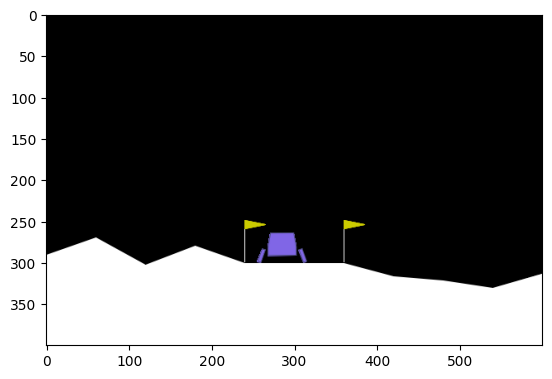

In [33]:
# Visualize the model
import gymnasium as gym
import os
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

def visualize_model(name, atype='single'):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    agent = DoubleQAgent(gamma=0.99, epsilon=0.0, lr=0.0005, mem_size=200000, batch_size=64, epsilon_end=0.01)
    agent.load_saved_model(name)
    state, info = env.reset(seed=42)
    for _ in range(5):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state
            clear_output(wait=True)
            plt.imshow( env.render() )
            plt.show()
        state = env.reset()[0]
    env.close()

visualize_model('double_torch_dqn_model.h5', atype='double')